In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math
from plotnine import *

In [2]:
#@title A/B Testing 實驗範例

contingency_table = np.array([[8000, 20000-8000], [8200, 20000-8200]])
print('A/B Testing KPI 以「次日留存率」為例：今日首次安裝 APP 的用戶，隔日會再次使用的比率\n')
print('範例：兩組樣本數各為 20,000 人。假設現有設計（A 組）留存率為 40%，而且 B 組的設計確實讓留存率提高到 41%\n')
print(pd.DataFrame(contingency_table, index = ["A 組（控制組）", "B 組（實驗組）"], columns = ["次日留存", "非次日留存"]))
print(f'\n卡方檢定 P-Value: {stats.chi2_contingency(contingency_table)[1]:.3f}')
print('\nP-value < 0.05，結論 B 組確實較好、採用 B 組為 APP 新設計')

A/B Testing KPI 以「次日留存率」為例：今日首次安裝 APP 的用戶，隔日會再次使用的比率

範例：兩組樣本數各為 20,000 人。假設現有設計（A 組）留存率為 40%，而且 B 組的設計確實讓留存率提高到 41%

          次日留存  非次日留存
A 組（控制組）  8000  12000
B 組（實驗組）  8200  11800

卡方檢定 P-Value: 0.043

P-value < 0.05，結論 B 組確實較好、採用 B 組為 APP 新設計


A/B 兩組實際上並無 KPI 成效差異，然而樣本數不足就提早結束實驗，更容易受 P-Value 誤導，導致錯誤決策


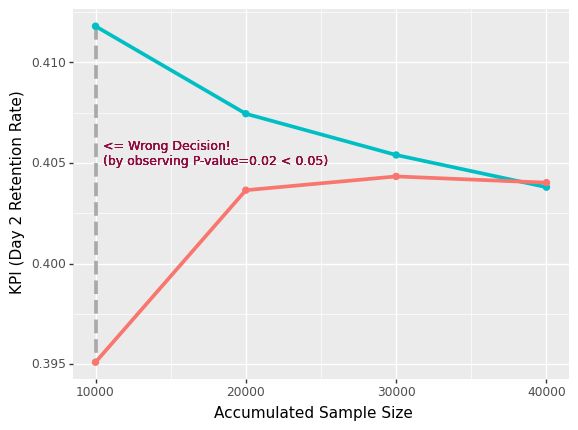

<ggplot: (-9223363288103140506)>

In [3]:
#@title 錯誤實驗導致錯誤決策 DEMO：A/A Testing With Early Stopping
np.random.seed(45)
n_trials = np.cumsum([10000]*4)
a_trials = np.cumsum(np.random.binomial(n=10000, p=0.4, size=4))
b_trials = np.cumsum(np.random.binomial(n=10000, p=0.4, size=4))
test_for_trials = [
  stats.chi2_contingency(np.array([[a_trials[i], n_trials[i]-a_trials[i]], [b_trials[i], n_trials[i]-b_trials[i]]]))[1] 
    for i in range(4)]
print("A/B 兩組實際上並無 KPI 成效差異，然而樣本數不足就提早結束實驗，更容易受 P-Value 誤導，導致錯誤決策")
df = pd.DataFrame({"Accumulated Sample Size": n_trials, 
          "A Group KPI": a_trials / n_trials, 
          "B Group KPI": b_trials / n_trials,
          "P-Value": test_for_trials})
(
    ggplot(data=df, mapping=aes(x="Accumulated Sample Size"))
    + geom_segment(data = df[df["P-Value"]<0.05].head(1), 
            mapping = aes(x="Accumulated Sample Size",
                    xend="Accumulated Sample Size",
                    y="A Group KPI",
                    yend="B Group KPI"),
            colour="darkgrey",
            linetype = "dashed",
            size = 1.5) 
    + geom_text(x = 10500, y = 0.4055, 
           label = f'<= Wrong Decision!\n(by observing P-value={df["P-Value"][df["P-Value"]<0.05][0]:.2f} < 0.05)', 
           size = 9, hjust = 'left',
           colour = "#900C3F")
    + geom_line(mapping=aes(y="A Group KPI"), colour = "#00BFC4", size = 1.5)
    + geom_point(mapping=aes(y="A Group KPI"), colour = "#00BFC4", size = 2)
    + geom_line(mapping=aes(y="B Group KPI"), colour = "#F8766D", size = 1.5)
    + geom_point(mapping=aes(y="B Group KPI"), colour = "#F8766D", size = 2)
    + labs(x="Accumulated Sample Size", y="KPI (Day 2 Retention Rate)")
)

In [4]:
#@title 執行一次 A/B Testing 之函式

def test(base_prob, absolute_effect_size, early_stopping=False, sample_size_per_group=40000, total_steps=4):
  """ return (if_early_stopped, p_value) """
  survey_step_sample_size = math.ceil(sample_size_per_group / total_steps)
  a_trials = np.cumsum(np.random.binomial(n=survey_step_sample_size, p=base_prob, size=total_steps))
  b_trials = np.cumsum(np.random.binomial(n=survey_step_sample_size, p=base_prob+absolute_effect_size, size=total_steps))

  def _get_contingency_table(i):
    contingency_table = np.array([[a_trials[i], survey_step_sample_size*(i+1)-a_trials[i]], [b_trials[i], survey_step_sample_size*(i+1)-b_trials[i]]])
    return contingency_table

  if not early_stopping:
    p_value = stats.chi2_contingency(_get_contingency_table(total_steps-1))[1]
    return (False, p_value)
  else:
    for i in range(0, total_steps):
      p_value = stats.chi2_contingency(_get_contingency_table(i))[1]
      if p_value < 0.05: return ((i+1)<total_steps, p_value)
    return (False, p_value)

In [7]:
#@title 主要實驗
np.random.seed(42)
base_retention = 0.4 # 基礎數據（現有次日留存率 40%）
absolute_retention_effect_size = 0.01 # 期望看到的數據差異（如果次日留存率沒有顯著相差至少 1%，就不採用實驗組設定）
n_ab_testing = 200 # A/B Testing 重複試驗的次數
sample_size_per_group = 40000 # A/B 兩組各別的樣本數

required_sample_size_per_group = math.ceil(16 * (base_retention * (1 - base_retention)) / absolute_retention_effect_size**2)
print(f'建議每組最小樣本數: {required_sample_size_per_group}   （Statistical power = 80% and Significance level = 5%）')
print(f'實際採用每組樣本數: {sample_size_per_group}')

print()
print(f'A/A Testing: 設定 A/B 兩組，但是兩組並不存在成效差異，次日留存率都是　{base_retention}')
print(f'A/B Testing: 設定　B 組比　A 組次日留存率高　{absolute_retention_effect_size}')
print('提前結束: 每蒐集建議樣本數的 25% 就檢查一次結果，若 A/B 兩組存在顯著差異，則提早結束實驗\n')

## Multiple A/B Testing Without Early Stopping
ab_testing_without_early_stopping = [test(base_prob=base_retention, absolute_effect_size=absolute_retention_effect_size, early_stopping=False, sample_size_per_group=sample_size_per_group) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/B Testing，堅持到樣本數足夠才結束實驗　（正確　A/B Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in ab_testing_without_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in ab_testing_without_early_stopping if result[0]]) / n_ab_testing, 4)}\n')
## Multiple A/B Testing With Early Stopping
ab_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=absolute_retention_effect_size, early_stopping=True, sample_size_per_group=sample_size_per_group) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/B Testing，若顯著則提前結束實驗　（*錯誤*　A/B Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in ab_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in ab_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')
## Multiple A/A Testing Without Early Stopping
aa_testing_without_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=False, sample_size_per_group=sample_size_per_group) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，堅持到樣本數足夠才結束實驗　（正確　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_without_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_without_early_stopping if result[0]]) / n_ab_testing, 4)}\n')
## Multiple A/A Testing With Early Stopping
aa_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=True, sample_size_per_group=sample_size_per_group) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，若顯著則提前結束實驗　（*錯誤*　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')

## Multiple A/A Testing With Early Stopping, Different Peeking Frequency
print()
print('上述提前結束的設定，都是每 25% 的樣本數偷看一次')
print('隨著偷看頻率提高，偽陽性的錯誤決策機率也會提高\n')

aa_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=True, sample_size_per_group=sample_size_per_group, total_steps=2) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，若顯著則提前結束實驗，每 33.3% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')

aa_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=True, sample_size_per_group=sample_size_per_group, total_steps=4) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，若顯著則提前結束實驗，每 25% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')

aa_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=True, sample_size_per_group=sample_size_per_group, total_steps=10) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，若顯著則提前結束實驗，每 10% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')

aa_testing_with_early_stopping = [test(base_prob=base_retention, absolute_effect_size=0, early_stopping=True, sample_size_per_group=sample_size_per_group, total_steps=20) for _ in range(n_ab_testing)]
print(f'{n_ab_testing} 次 A/A Testing，若顯著則提前結束實驗，每 5% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）\n'
   f'  有顯著差異的實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[1] < 0.05]) / n_ab_testing, 4)}\n'
   f'  提早結束實驗比例：{round(sum([1 for result in aa_testing_with_early_stopping if result[0]]) / n_ab_testing, 4)}\n')

建議每組最小樣本數: 38400   （Statistical power = 80% and Significance level = 5%）
實際採用每組樣本數: 40000

A/A Testing: 設定 A/B 兩組，但是兩組並不存在成效差異，次日留存率都是　0.4
A/B Testing: 設定　B 組比　A 組次日留存率高　0.01
提前結束: 每蒐集建議樣本數的 25% 就檢查一次結果，若 A/B 兩組存在顯著差異，則提早結束實驗

200 次 A/B Testing，堅持到樣本數足夠才結束實驗　（正確　A/B Testing 實驗方法）
  有顯著差異的實驗比例：0.755
  提早結束實驗比例：0.0

200 次 A/B Testing，若顯著則提前結束實驗　（*錯誤*　A/B Testing 實驗方法）
  有顯著差異的實驗比例：0.835
  提早結束實驗比例：0.725

200 次 A/A Testing，堅持到樣本數足夠才結束實驗　（正確　A/A Testing 實驗方法）
  有顯著差異的實驗比例：0.05
  提早結束實驗比例：0.0

200 次 A/A Testing，若顯著則提前結束實驗　（*錯誤*　A/A Testing 實驗方法）
  有顯著差異的實驗比例：0.105
  提早結束實驗比例：0.08


上述提前結束的設定，都是每 25% 的樣本數偷看一次
隨著偷看頻率提高，偽陽性的錯誤決策機率也會提高

200 次 A/A Testing，若顯著則提前結束實驗，每 33.3% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）
  有顯著差異的實驗比例：0.065
  提早結束實驗比例：0.035

200 次 A/A Testing，若顯著則提前結束實驗，每 25% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）
  有顯著差異的實驗比例：0.105
  提早結束實驗比例：0.09

200 次 A/A Testing，若顯著則提前結束實驗，每 10% 的樣本數偷看一次　（*錯誤*　A/A Testing 實驗方法）
  有顯著差異的實驗比例：0.185
  提早結束實驗比例：0.18

200 次 A/A Testing，若顯著則提前結束實驗，每 5% 的樣本數偷看一次　（*錯誤*　